In [15]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import kornia as K
import kornia.feature as KF
import preprocessing
import validation
import plotting

import warnings
warnings.filterwarnings("ignore")

input_dir = '../../data/train/' # directory of the training data

In [ ]:
# for use with MacBooks
# pip install torch

# for use with AMD GPUs
# pip3 install torch --extra-index-url https://download.pytorch.org/whl/rocm5.1.1

In [2]:
all_scenes = preprocessing.get_scenes(input_dir)
all_scenes 

['brandenburg_gate',
 'british_museum',
 'buckingham_palace',
 'colosseum_exterior',
 'grand_place_brussels',
 'lincoln_memorial_statue',
 'notre_dame_front_facade',
 'pantheon_exterior',
 'piazza_san_marco',
 'sacre_coeur',
 'sagrada_familia',
 'st_pauls_cathedral',
 'st_peters_square',
 'taj_mahal',
 'temple_nara_japan',
 'trevi_fountain']

In [3]:
scenes = all_scenes
pairs = preprocessing.load_pairs(scenes,input_dir)
pairs = pairs.query('covisibility > 0.95').reset_index()
pairs

loading category 1 of 16: brandenburg_gate
loading category 2 of 16: british_museum
loading category 3 of 16: buckingham_palace
loading category 4 of 16: colosseum_exterior
loading category 5 of 16: grand_place_brussels
loading category 6 of 16: lincoln_memorial_statue
loading category 7 of 16: notre_dame_front_facade
loading category 8 of 16: pantheon_exterior
loading category 9 of 16: piazza_san_marco
loading category 10 of 16: sacre_coeur
loading category 11 of 16: sagrada_familia
loading category 12 of 16: st_pauls_cathedral
loading category 13 of 16: st_peters_square
loading category 14 of 16: taj_mahal
loading category 15 of 16: temple_nara_japan
loading category 16 of 16: trevi_fountain


,index,pair,covisibility,fundamental_matrix,scene
0,0,95149062_6032288272-93398566_312325000,0.985,-2.38480981e-03 -9.33062611e-01 2.91327859e+02...,colosseum_exterior
1,1,95149062_6032288272-92817674_6031728525,0.980,-1.32451595e-02 -1.60948244e+00 5.04081199e+02...,colosseum_exterior
2,11,93398566_312325000-92817674_6031728525,0.952,-3.86271969e-03 -7.23156867e-01 1.09036438e+02...,colosseum_exterior
3,15,39677256_2268030810-14604839_328499059,0.951,1.53860420e-02 -1.39691884e-01 2.32381134e+02 ...,notre_dame_front_facade
4,16,39677256_2268030810-17284650_9042377,0.972,-1.42242644e-02 5.90917856e-02 -1.40190916e+02...,notre_dame_front_facade
...,...,...,...,...,...
229,1242,56493755_3454995877-15742678_3009023364,0.984,4.11571115e-02 1.96290339e+00 -1.37312969e+03 ...,trevi_fountain
230,1248,57385155_2810071-30725650_6031692319,0.968,-5.93780841e-03 9.39645380e-01 -9.26060850e+02...,trevi_fountain
231,1262,59170911_4886168484-07476872_3383479312,0.959,-1.07764646e-01 -5.75958794e-01 2.39339573e+02...,trevi_fountain
232,1288,59954281_5721627661-30725650_6031692319,0.964,1.68470250e-02 -1.20024590e+00 1.28358835e+03 ...,trevi_fountain


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
# Initialize LoFTR
matcher = KF.LoFTR(pretrained='outdoor')
matcher = matcher.to(device).eval()

In [7]:
scene_list = []
fund_matrix_list = []
pair_list = []
fund_matrix_eval = []
pair_eval = []
mkpts0_list = []
mkpts1_list = []
mconf_list = []

for index, row in pairs.head(20).iterrows():
    
    split_pair = pairs.pair[index].split('-')
    img_id0 = split_pair[0]
    img_id1 = split_pair[1]
    
    img0_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id0 + '.jpg'))
    img1_pth = os.path.join(input_dir, pairs.scene[index], "images", str(img_id1 + '.jpg'))
    img0 = preprocessing.load_torch_image(img0_pth, device)
    img1 = preprocessing.load_torch_image(img1_pth, device)
    batch = {"image0": K.color.rgb_to_grayscale(img0), 
            "image1": K.color.rgb_to_grayscale(img1)}
    
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
        
    F = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.99999, 50000)
    
    scene_list.append(pairs.scene[index])
    fund_matrix_list.append(F[0])
    pair_list.append(pairs.pair[index])
    fund_matrix_eval.append(" ".join(str(num) for num in F[0].flatten().tolist()))
    pair_eval.append(";".join(["phototourism",pairs.scene[index],pairs.pair[index]]))
    mkpts0_list.append(mkpts0)
    mkpts1_list.append(mkpts1)
    mconf_list.append(mconf)
    
results = pd.DataFrame({'scene': scene_list, 'pair': pair_list, 'fund_matrix': fund_matrix_list, 
                        'mkpts0': mkpts0_list, 'mkpts1': mkpts1_list, 'mconf': mconf_list,
                        'pair_eval': pair_eval, 'fund_matrix_eval': fund_matrix_eval}) 

maa = validation.evaluate(input_dir, pair_eval, fund_matrix_eval)
print(f'mAA={maa:.05f} (n={len(pair_list)})')

mAA=0.09118 (n=20)


In [8]:
results

,scene,pair,fund_matrix,mkpts0,mkpts1,mconf,pair_eval,fund_matrix_eval
0,colosseum_exterior,95149062_6032288272-93398566_312325000,"[[-1.7423213636089393e-06, -7.707876503416011e...","[[264.0, 72.0], [544.0, 72.0], [528.0, 88.0], ...","[[32.668705, 88.54875], [344.46152, 16.93146],...","[0.24776568, 0.2876771, 0.30743164, 0.23158924...",phototourism;colosseum_exterior;95149062_60322...,-1.7423213636089393e-06 -7.707876503416011e-06...
1,colosseum_exterior,95149062_6032288272-92817674_6031728525,"[[4.7658597995277467e-07, -3.6860335392777143e...","[[416.0, 40.0], [136.0, 48.0], [424.0, 48.0], ...","[[449.49637, 294.47726], [288.7323, 329.62402]...","[0.29785085, 0.44049135, 0.2855176, 0.37792465...",phototourism;colosseum_exterior;95149062_60322...,4.7658597995277467e-07 -3.6860335392777143e-06...
2,colosseum_exterior,93398566_312325000-92817674_6031728525,"[[-5.0014721428525365e-08, 3.447023266234883e-...","[[191.39241, 15.949368], [199.3671, 15.949368]...","[[632.06946, 151.6751], [639.35443, 151.63799]...","[0.21359386, 0.48653483, 0.26730704, 0.6123819...",phototourism;colosseum_exterior;93398566_31232...,-5.0014721428525365e-08 3.447023266234883e-06 ...
3,notre_dame_front_facade,39677256_2268030810-14604839_328499059,"[[-1.388184202275822e-07, 1.3666505700093943e-...","[[64.0, 16.0], [72.0, 16.0], [80.0, 16.0], [88...","[[40.320095, 23.331701], [47.26755, 22.742443]...","[0.74417454, 0.88372517, 0.95708424, 0.9373361...",phototourism;notre_dame_front_facade;39677256_...,-1.388184202275822e-07 1.3666505700093943e-06 ...
4,notre_dame_front_facade,39677256_2268030810-17284650_9042377,"[[1.1751039811587237e-07, -1.0698689434982513e...","[[88.0, 16.0], [120.0, 16.0], [128.0, 16.0], [...","[[18.297985, 17.774822], [55.018333, 20.78086]...","[0.25952706, 0.24221063, 0.62763125, 0.5037676...",phototourism;notre_dame_front_facade;39677256_...,1.1751039811587237e-07 -1.0698689434982513e-06...
5,notre_dame_front_facade,34662694_204929321-30992601_6981174639,"[[-9.123839336224643e-07, -3.264398663325477e-...","[[415.30667, 191.68], [383.36, 207.65334], [50...","[[461.05676, 492.52502], [320.2033, 231.35709]...","[0.42701712, 0.40890247, 0.35733557, 0.2565679...",phototourism;notre_dame_front_facade;34662694_...,-9.123839336224643e-07 -3.264398663325477e-05 ...
6,notre_dame_front_facade,32721367_3535359151-17202694_448671955,"[[1.3571000155910118e-06, 2.101805124135144e-0...","[[392.0, 16.0], [432.0, 16.0], [544.0, 16.0], ...","[[594.76227, 48.0294], [664.6809, 103.126785],...","[0.21685094, 0.2947335, 0.64546496, 0.2820195,...",phototourism;notre_dame_front_facade;32721367_...,1.3571000155910118e-06 2.101805124135144e-06 -...
7,notre_dame_front_facade,30992601_6981174639-27753051_8325233672,"[[-2.2838713826111042e-07, 1.0047947780385548e...","[[71.35714, 15.857142], [95.14285, 15.857142],...","[[285.51645, 206.21051], [221.24017, 332.13535...","[0.39404395, 0.3609588, 0.7936812, 0.77172107,...",phototourism;notre_dame_front_facade;30992601_...,-2.2838713826111042e-07 1.0047947780385548e-06...
8,notre_dame_front_facade,30992601_6981174639-15237267_2739291657,"[[8.664545088506647e-07, 5.365208768959039e-05...","[[523.2857, 15.857142], [784.9285, 15.857142],...","[[530.05255, 277.28653], [672.0857, 286.0116],...","[0.44900435, 0.23358616, 0.3638673, 0.5957579,...",phototourism;notre_dame_front_facade;30992601_...,8.664545088506647e-07 5.365208768959039e-05 -0...
9,notre_dame_front_facade,30992601_6981174639-17056809_6943969496,"[[-1.1168341988873249e-07, -1.2044321621198195...","[[111.0, 15.857142], [174.42857, 15.857142], [...","[[372.68945, 286.38373], [389.22922, 284.5217]...","[0.429733, 0.5313238, 0.29140428, 0.21671104, ...",phototourism;notre_dame_front_facade;30992601_...,-1.1168341988873249e-07 -1.2044321621198195e-0...


In [9]:
maa = validation.evaluate(input_dir, results.pair_eval, results.fund_matrix_eval)
print(f'mAA={maa:.05f} (n={len(results)})')

mAA=0.09118 (n=20)


In [72]:
from sklearn.cluster import DBSCAN
X = results.mkpts0[10]
Y = results.mkpts1[10]

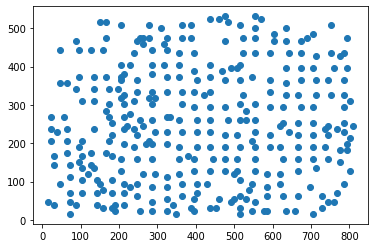

In [73]:
plt.scatter(X[:, 0], X[:, 1])

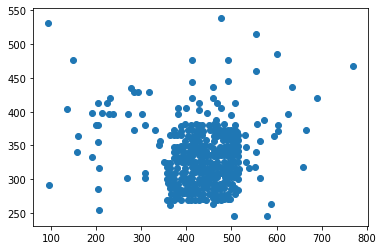

In [74]:
plt.scatter(Y[:, 0], Y[:, 1])

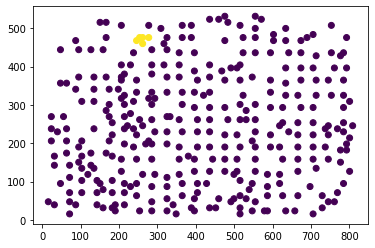

In [97]:
clustering = DBSCAN(eps=20, min_samples=5).fit(X)
plt.scatter(X[:, 0], X[:, 1], c = clustering.labels_)

ToDo: 
- decompose F and plot
- DBSCAN

## LoFTR example on single image pair

In [19]:
# Initialize LoFTR and load two images
# matcher.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
matcher = KF.LoFTR(pretrained='outdoor')
matcher = matcher.to('cpu').eval()

img0_pth = "../../data/test_images/1cf87530/0143f47ee9e54243a1b8454f3e91621a.png"
img1_pth = "../../data/test_images/1cf87530/a5a9975574c94ff9a285f58c39b53d2c.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None] / 255.
img1 = torch.from_numpy(img1_raw)[None][None] / 255.
batch = {'image0': img0, 'image1': img1}

In [20]:
# Inference with LoFTR and get prediction
# torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

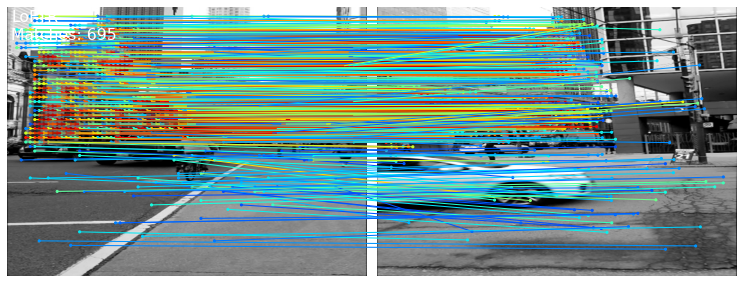

In [21]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0))]
fig = plotting.make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)